In [50]:
import matplotlib
import numpy as np
import psutil
import ray
import os
import seaborn as sns
import time

import matplotlib.pyplot as plt
import numpy.linalg as la

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [51]:
iterations = 800
num_workers = 40
it_check = 40 # 每隔 it_check 次迭代记录一次数据
n_seeds = 5 # 
max_seed = 424242 #
rng = np.random.default_rng(42)
# seeds = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(n_seeds)] # seeds 里的随机种子是有可能相同的。
seeds = rng.choice(max_seed, size=n_seeds, replace=False) # seeds 里的随机种子是不会相同的。
seed_to_run = {}
for r, seed in enumerate(seeds):
    seed_to_run[seed] = r
    
n_data = 10000
dim = 400
batch_size = 256
noise_scale = 1e-2
A = rng.uniform(size=(n_data, dim)) / np.sqrt(dim)
x_rand = rng.normal(size=dim)
b = A @ x_rand + noise_scale * rng.normal(size=n_data)

In [52]:
@ray.remote
class ParameterServer(object):
    def __init__(self, lr, asynchronous):
        self.x = np.zeros(dim)
        self.lr = lr
        self.asynchronous = asynchronous

    def apply_gradients(self, grad, *gradients):
        # *把一串位置参数打包到一个元组里
        if self.asynchronous:
            self.x -= self.lr * grad
        else:
            summed_gradients = np.sum(gradients, axis=0)
            self.x -= self.lr * summed_gradients
        return self.x

    def get_x(self):
        return self.x
    
    def update_lr(self, lr_coef_mul=1, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new
        else:
            self.lr *= lr_coef_mul
        
    def get_hyperparams(self):
        return self.lr, self.asynchronous

In [53]:
def grad_func(x):
    return (A@x - b) @ A / n_data

def sgrad_func(rng, x):
    i = rng.integers(n_data)
    return (A[i]@x - b[i]) * A[i]

def batch_grad_func(rng, x, batch_size):
    idx = rng.choice(n_data, size=batch_size, replace=False)
    return (A[idx]@x - b[idx]) @ A[idx] / batch_size

@ray.remote
class DataWorker(object):
    """
    The class for an individual Ray worker.
    Arguments:
        lr (float): the stepsize to be used at initialization
        label (int, optional): batch size for sampling gradients (default: 1)
        seed (int, optional): random seed to generate random variables for reproducibility (default: 0)
        bad_worker (bool, optional): if True, the worker will be forced to be slower than others (default: False)
    """
    def __init__(self, lr, batch_size=1, seed=0, bad_worker=False):
        self.lr = lr
        self.batch_size = batch_size
        self.bad_worker = bad_worker
        self.rng = np.random.default_rng(seed)

    def compute_gradients(self, x):
        t0 = time.perf_counter()
        if self.batch_size is None:
            grad = grad_func(x)
        elif self.batch_size == 1:
            grad = sgrad_func(self.rng, x)
        else:
            grad = batch_grad_func(self.rng, x, self.batch_size)
        if self.bad_worker:
            dt = time.perf_counter() - t0
            time.sleep(100 * dt)
        return grad
    
    def update_lr(self, lr_coef_mul=1, lr_new=None):
        if lr_new is not None:
            self.lr = lr_new
        else:
            self.lr *= lr_coef_mul
        
    def get_hyperparams(self):
        return self.lr, self.batch_size
    
    def get_lr(self):
        return self.lr

In [54]:
def evaluate(x):
    assert len(x) == dim
    return 0.5 * np.mean((A @ x - b)**2)

In [55]:
def run(seeds, num_workers, lr, lr_decay=0, iterations=200, asynchronous=True, delay_adaptive=False, it_check=20,
        batch_size=1, one_bad_worker=False):
    worker_updates = [0 for i in range(num_workers)]
    rng = np.random.default_rng(42)
    seeds_workers = rng.choice(max_seed, size=num_workers, replace=False)
    #seeds_workers = [rng.choice(max_seed, size=1, replace=False)[0] for _ in range(num_workers)]

    ray.init(ignore_reinit_error=True)
    ps = ParameterServer.remote(lr, asynchronous)
    workers = [DataWorker.remote(lr=lr, batch_size=batch_size, seed=seeds_workers[i]) for i in range(num_workers)]

    x = ps.get_x.remote()
    if asynchronous:
        gradients = {}
        worker_last_it = [0 for _ in range(num_workers)]
        worker_id_to_num = {}
        for e, worker in enumerate(workers):
            gradients[worker.compute_gradients.remote(x)] = worker
            worker_id_to_num[worker] = e


    its = []
    ts = []
    delays = []
    t0 = time.perf_counter()
    delay = 0
    trace = []
    grads_per_it = 1 if asynchronous else num_workers

    for it in range(iterations * (num_workers if asynchronous else 1)):
        n_grads = it * grads_per_it # 异步时n_grads = it；同步时n_grads = it * num_workers
        if asynchronous:
            ready_gradient_list, _ = ray.wait(list(gradients),num_returns=1) #ray.wait作用在任务句柄的列表上，返回已经完成的任务句柄列表和未完成的任务句柄列表，只返回一个已经完成的任务句柄。
            print(ready_gradient_list)
            print(len(ready_gradient_list))
            ready_gradient_id = ready_gradient_list[-1]
            worker = gradients.pop(ready_gradient_id) #从字典 gradients 中，删除并返回 key 为 ready_gradient_id 的那个 value（也就是对应的 worker 对象

            # Compute and apply gradients.
            gradients[worker.compute_gradients.remote(x)] = worker # 重新计算该 worker 的梯度，并将新的任务句柄存回 gradients 字典
            worker_num = worker_id_to_num[worker] # 获取该 worker 的编号
            delay = it - worker_last_it[worker_num] # 计算该 worker 的延迟
            if delay_adaptive:
                lr_new = lr * num_workers / max(num_workers, delay)
                # lr_new = lr * num_workers / max(num_workers, delay)
                ps.update_lr.remote(lr_new=lr_new)
            x = ps.apply_gradients.remote(grad=ready_gradient_id) # 针对已经计算完成的梯度进行参数更新
            worker_last_it[worker_num] = it
            worker_updates[worker_num] += 1
        else:
            gradients = [
                worker.compute_gradients.remote(x) for worker in workers
            ]
            # Calculate update after all gradients are available.
            x = ps.apply_gradients.remote(None, *gradients)

        if it % it_check == 0 or (not asynchronous and it % (max(it_check // num_workers, 1)) == 0):
            # Evaluate the current model.
            x = ray.get(ps.get_x.remote())
            trace.append(x.copy())
            its.append(it)
            ts.append(time.perf_counter() - t0)

        lr_new = lr / (1 + lr_decay * n_grads)
        ps.update_lr.remote(lr_new=lr_new)
        t = time.perf_counter()
        if asynchronous:
            delays.append(delay)

    ray.shutdown()
    return np.asarray(its), np.asarray(ts), np.asarray([evaluate(x) for x in trace]), np.asarray(delays)

## Parameters

In [56]:
print(psutil.cpu_count(logical=True))

152

In [57]:
x_opt, _, _, _ = np.linalg.lstsq(A, b)
f_min = evaluate(x_opt)
print(f"Optimal value: {f_min:.6e}")

## Synchronous

In [58]:
lr_mini = 0.19 # best tuned
lr_decay = 0
its_, ts_, losses_, _ = run(seeds, num_workers, lr=lr_mini, lr_decay=lr_decay, iterations=iterations, 
                            asynchronous=False, delay_adaptive=False, it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2025-11-15 18:03:11,818	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [59]:
lr_as = 0.43 # best tuned
lr_decay = 0
its_as, ts_as, losses_as, _ = run(seeds, num_workers, lr=lr_as, lr_decay=lr_decay, 
                                  iterations=iterations, asynchronous=True, delay_adaptive=False, 
                                  it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2025-11-15 18:03:49,047	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


In [60]:
lr_ad = 0.43 # best tuned
lr_decay = 0
its_ad, ts_ad, losses_ad, delays = run(seeds, num_workers, lr=lr_ad, lr_decay=lr_decay, 
                                       iterations=iterations, asynchronous=True, delay_adaptive=True, 
                                       it_check=it_check, batch_size=batch_size, one_bad_worker=False)

2025-11-15 18:04:39,523	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(raylet) Warning: The actor DataWorker is very large (30 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Text(0, 0.5, '$F(\\mathbf{x}) - F^*$')

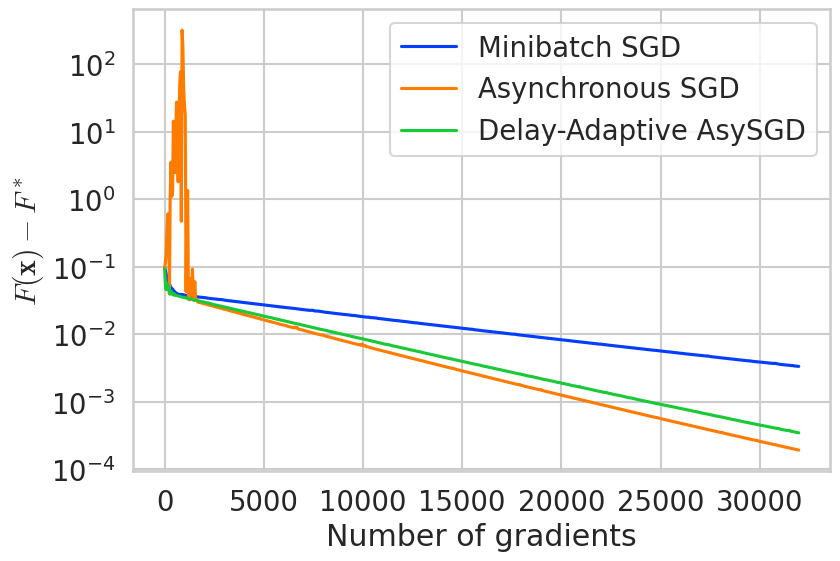

In [61]:
# plt.plot(its_ * num_workers, losses_ - f_min, label='Minibatch SGD')
# plt.plot(its_as, losses_as - f_min, label='Asynchronous SGD')
# plt.plot(its_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')
# plt.yscale('log')
# plt.legend()
# plt.xlabel('Number of gradients')
# plt.ylabel(r'$F(\mathbf{x}) - F^*$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')


plt.plot(ts_, losses_ - f_min, label='Minibatch SGD')
plt.plot(ts_as, losses_as - f_min, label='Asynchronous SGD')
plt.plot(ts_ad, losses_ad - f_min, label='Delay-Adaptive AsySGD')

plt.yscale('log')
plt.legend()
plt.xlabel('Time (seconds)')
plt.ylabel(r'$\mathbf{log}(F(\mathbf{x}) - F^*)$')
# plt.savefig(f'quadratic_grads_M_{num_workers}_n={n_data}_dim={dim}_bs_{batch_size}.pdf', bbox_inches='tight')

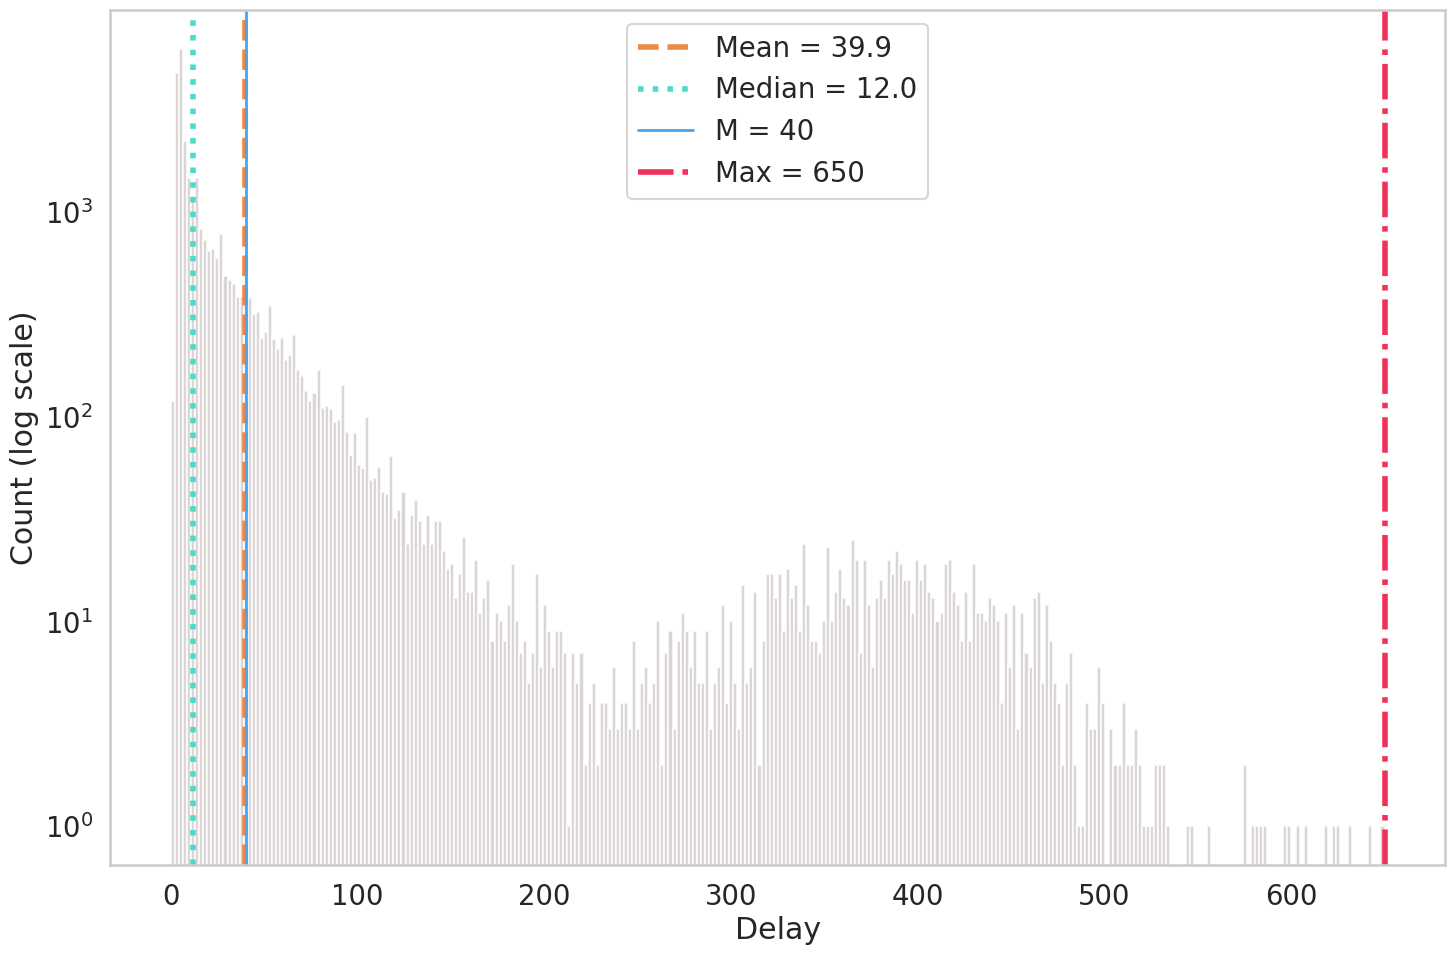

In [ ]:
plt.figure(figsize=(15,10))

# 延迟直方图（对数 y 轴）
plt.hist(delays, bins=300, color="#CEC6C6", alpha=0.75)
plt.yscale('log')

# 统计量
mean_delay = np.mean(delays)
median_delay = np.median(delays)
max_delay = np.max(delays)

plt.axvline(mean_delay, color="#f08843", linestyle='--', linewidth=4, label=f'Mean = {mean_delay:.1f}')
plt.axvline(median_delay, color="#4bdbc8", linestyle=':', linewidth=4, label=f'Median = {median_delay:.1f}')
plt.axvline(num_workers, color="#46a5ee", linestyle='-', linewidth=2, label=f'M = {num_workers}')
plt.axvline(max_delay, color="#f1315a", linestyle='-.', linewidth=4, label=f'Max = {max_delay:.0f}')
plt.grid(False)
plt.xlabel('Delay')
plt.ylabel('Count (log scale)')
plt.legend()
plt.tight_layout()
# # plt.savefig(f'quadratic_delays_M_{num_workers}_n={n_data}_dim={dim}_bs={batch_size}.pdf', bbox_inches='tight')


# plt.hist(delays, bins=600)
# plt.axvline(num_workers, color='green', label=r'$M$', linewidth=6)
# plt.axvline(np.max(delays), color='red', label=r'$\tau_{\max}$')
# plt.xlabel('Delay')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.legend()
# plt.savefig(f'quadratic_delays_M_{num_workers}_n={n_data}_dim={dim}_bs={batch_size}.pdf', bbox_inches='tight')